In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score
import gzip
import warnings
warnings.filterwarnings('ignore')

In [4]:
# setup the columns and open the file - Rolf Code
columns = [
    'karl_id', 'host_name', 'model_name', 'hardware_make', 'karl_last_seen',
    'auth_username', 'serial_number', 'group_id', 'tenant_id', 'platform',
    'metric_category', 'measure_name', 'time', 'p90_processor_time',
    'avg_processor_time', 'max_cpu_usage', 'p90_memory_utilization',
    'avg_memory_utilization', 'max_memory_usage', 'p10_battery_health',
    'avg_battery_health', 'cpu_count', 'memory_count', 'memory_size_gb',
    'driver_vendor', 'os', 'wifi_mac_add', 'driver_version', 'driver_date',
    'os_version', 'driver', 'agent_id', 'performance_status', 'device_status',
    'max_battery_temperature', 'avg_battery_temperature', 'p90_battery_temperature',
    'avg_cpu_temp', 'p90_cpu_temp', 'avg_battery_discharge', 'p90_battery_discharge',
    'avg_boot_time', 'p90_boot_time', 'uptime_days', 'total_app_crash'
]

chunk_size = 100000
sample_data = []
with gzip.open('000.gz', 'rt') as f:
    for i, chunk in enumerate(pd.read_csv(f, sep='|', names=columns, chunksize=chunk_size)):
        sample_data.append(chunk)
        if i >= 4:
            break

df = pd.concat(sample_data, ignore_index=True)

numeric_cols = ['avg_processor_time', 'max_cpu_usage', 'avg_memory_utilization',
                'max_memory_usage', 'avg_battery_health', 'cpu_count', 'memory_size_gb',
                'avg_cpu_temp', 'avg_boot_time', 'p90_boot_time', 'uptime_days', 'total_app_crash']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

host_stats = df.groupby('host_name').agg({
    'total_app_crash': 'mean',
    'avg_processor_time': 'mean',
    'avg_memory_utilization': 'mean',
    'avg_cpu_temp': 'mean',
    'avg_boot_time': 'mean',
    'uptime_days': 'mean',
    'max_cpu_usage': 'mean',
    'max_memory_usage': 'mean'
}).dropna()

In [ ]:
# kmean
scaler = StandardScaler()
X_scaled = scaler.fit_transform(host_stats)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

For n_clusters = 2 The average silhouette_score is : 0.23853730582152252
For n_clusters = 3 The average silhouette_score is : 0.2507401905316473
For n_clusters = 4 The average silhouette_score is : 0.2521031803608266
For n_clusters = 5 The average silhouette_score is : 0.2527137700255846
For n_clusters = 6 The average silhouette_score is : 0.23675759311579742
For n_clusters = 7 The average silhouette_score is : 0.24040676444928702
For n_clusters = 8 The average silhouette_score is : 0.20919863111174172
For n_clusters = 9 The average silhouette_score is : 0.20297870847455662
For n_clusters = 10 The average silhouette_score is : 0.20528474990925683
For n_clusters = 11 The average silhouette_score is : 0.2101009240627039
For n_clusters = 12 The average silhouette_score is : 0.2108960803712325
For n_clusters = 13 The average silhouette_score is : 0.19493121333473834
For n_clusters = 14 The average silhouette_score is : 0.1918537660208854
For n_clusters = 15 The average silhouette_score is 

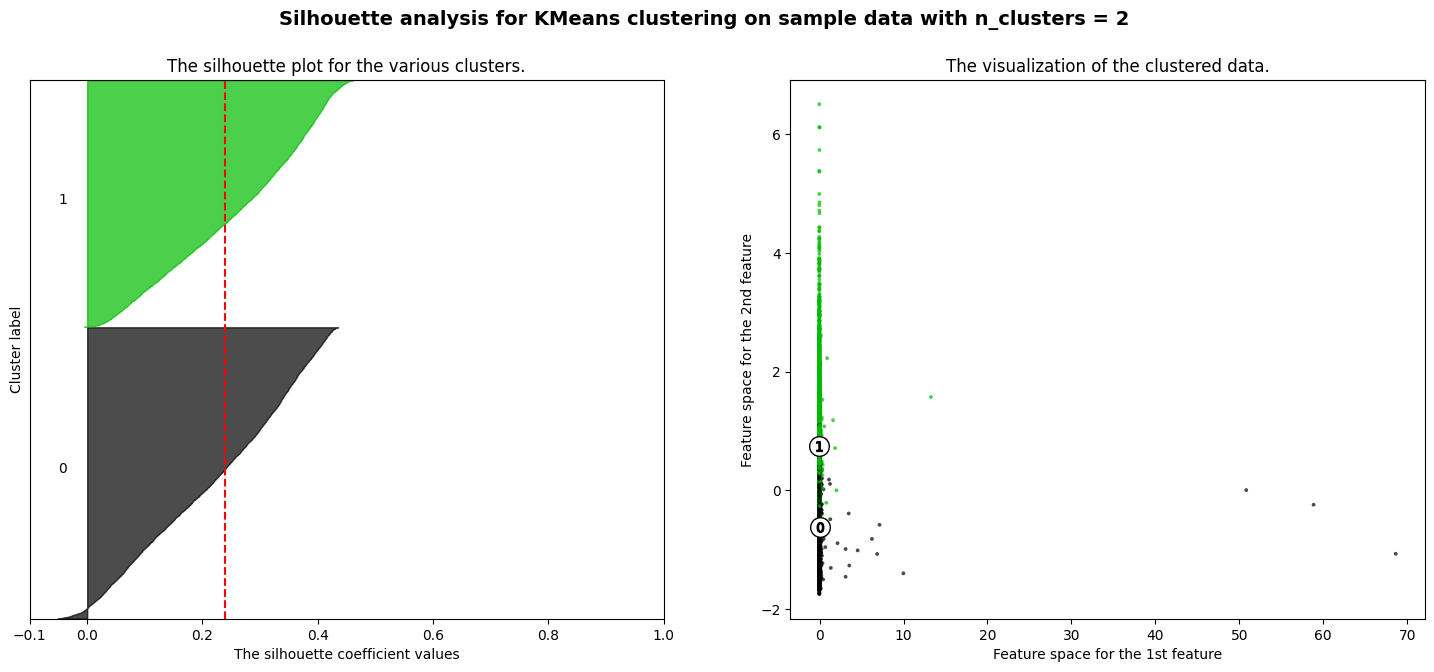

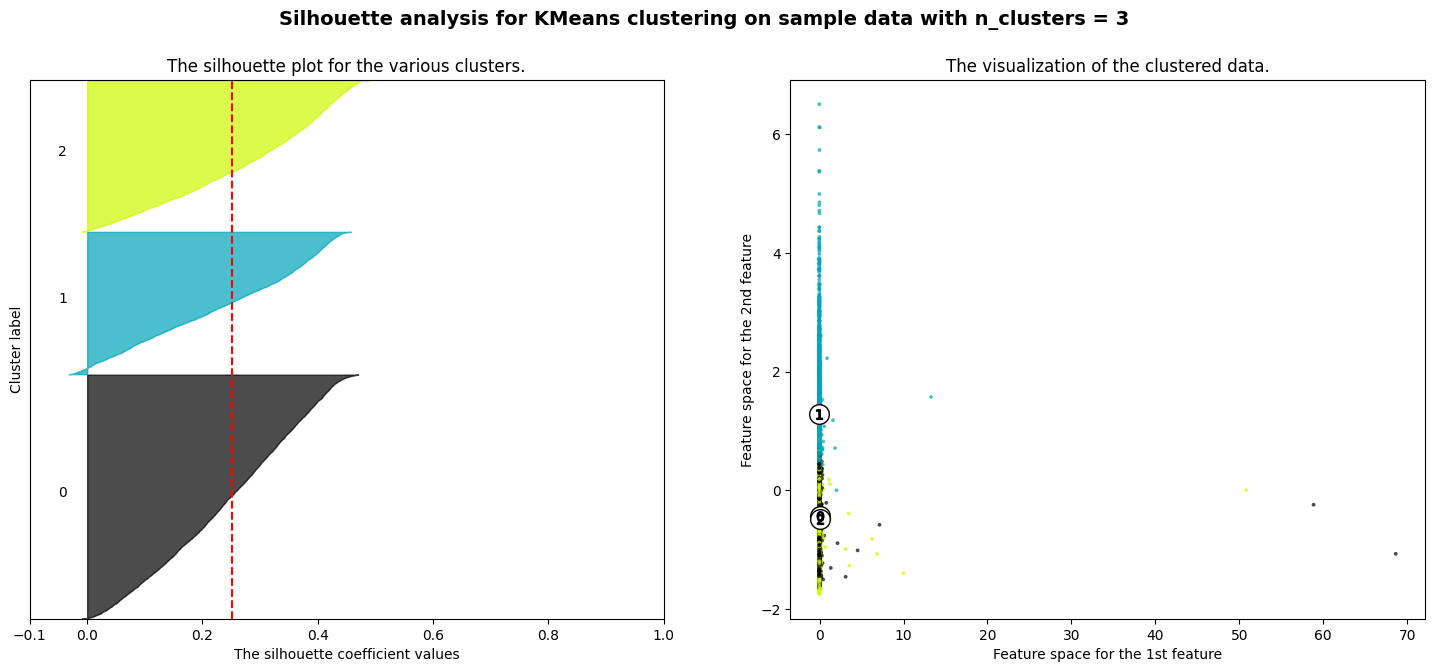

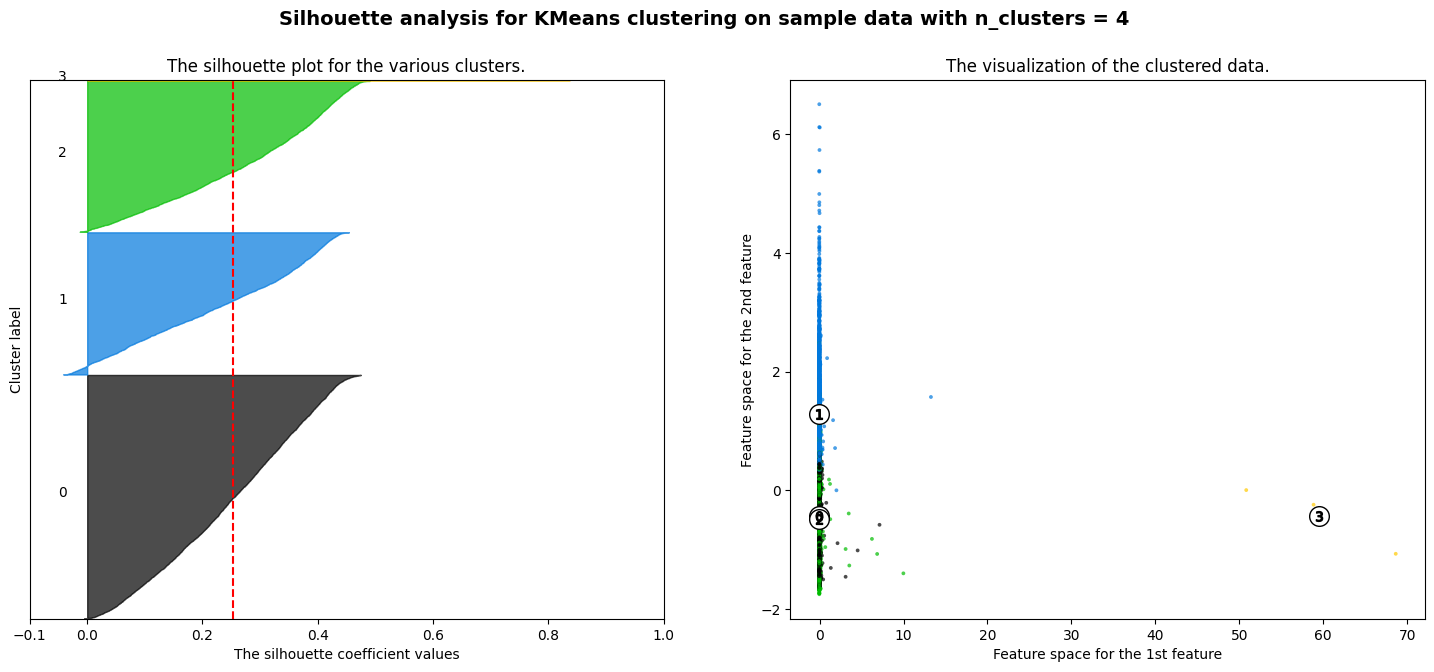

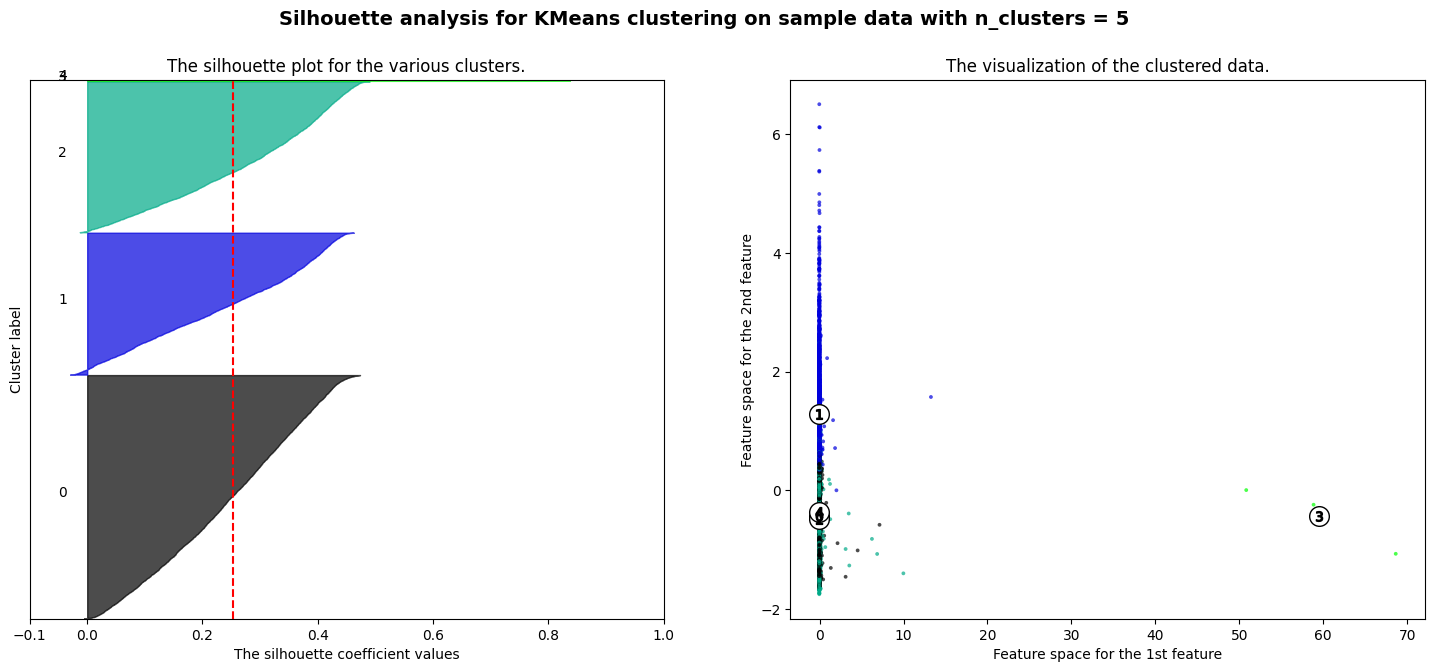

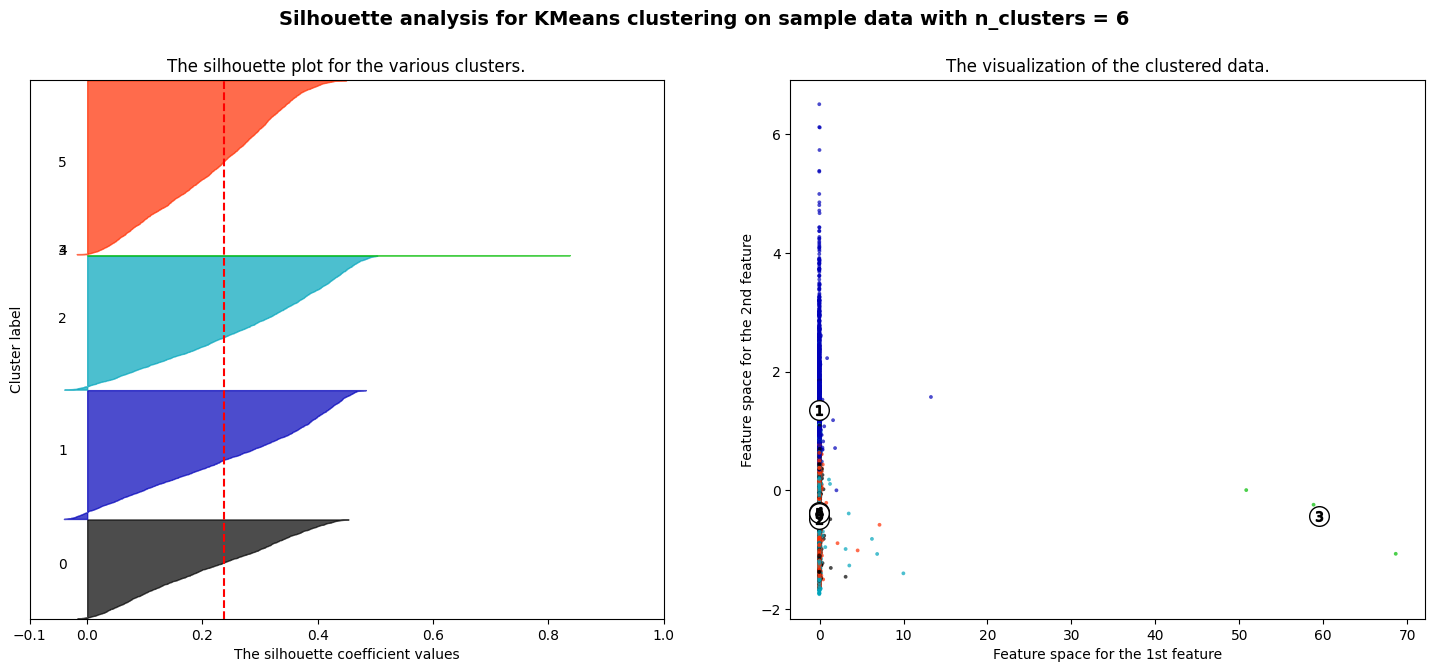

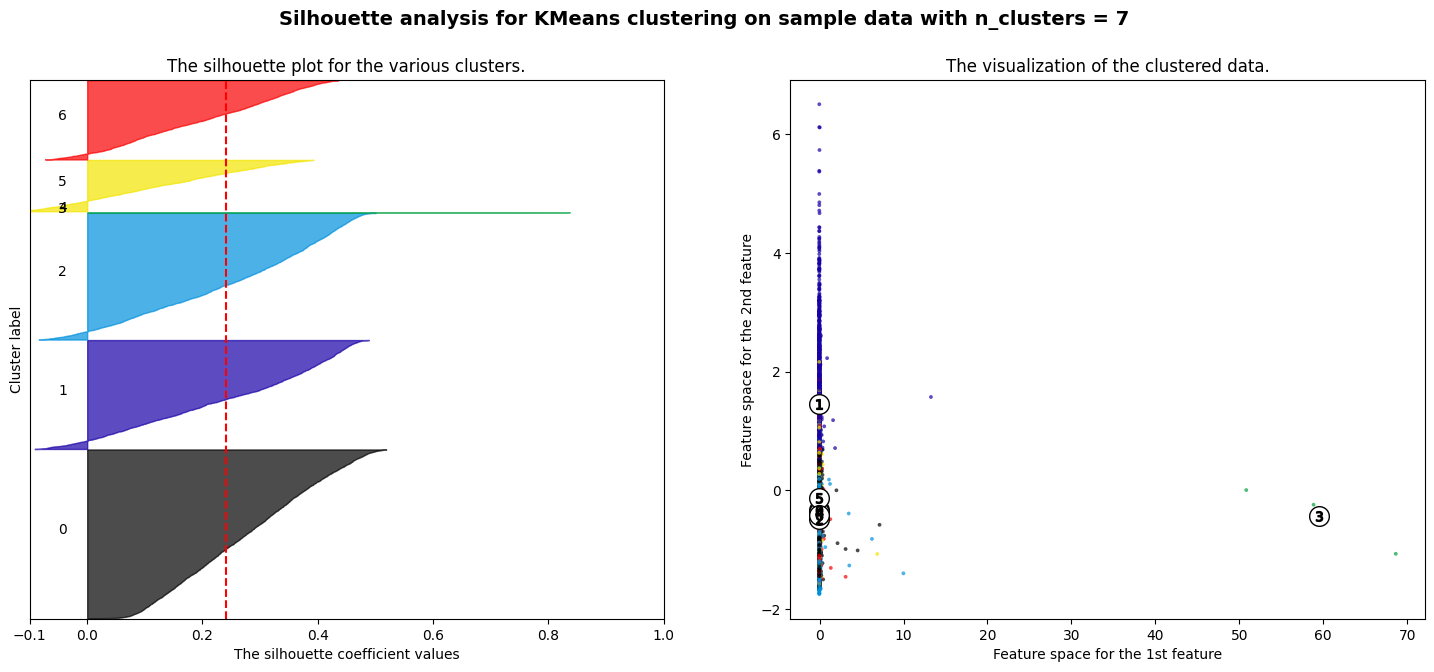

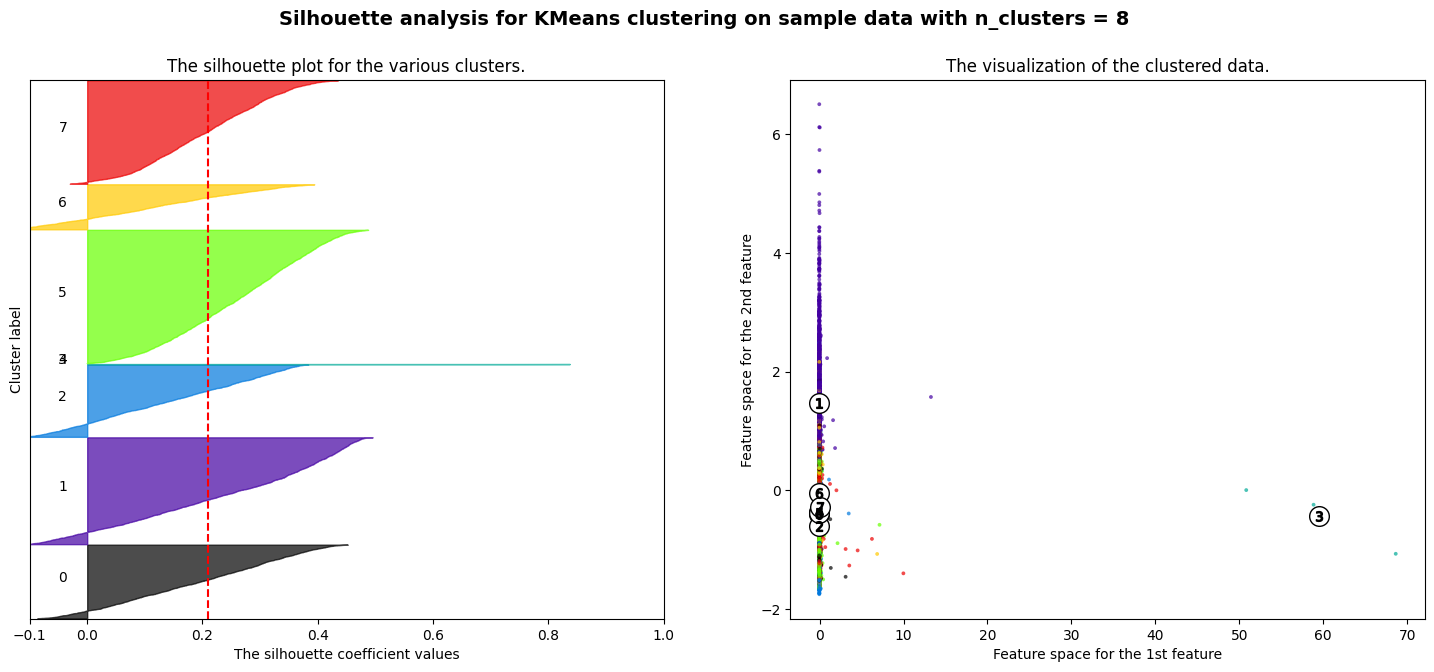

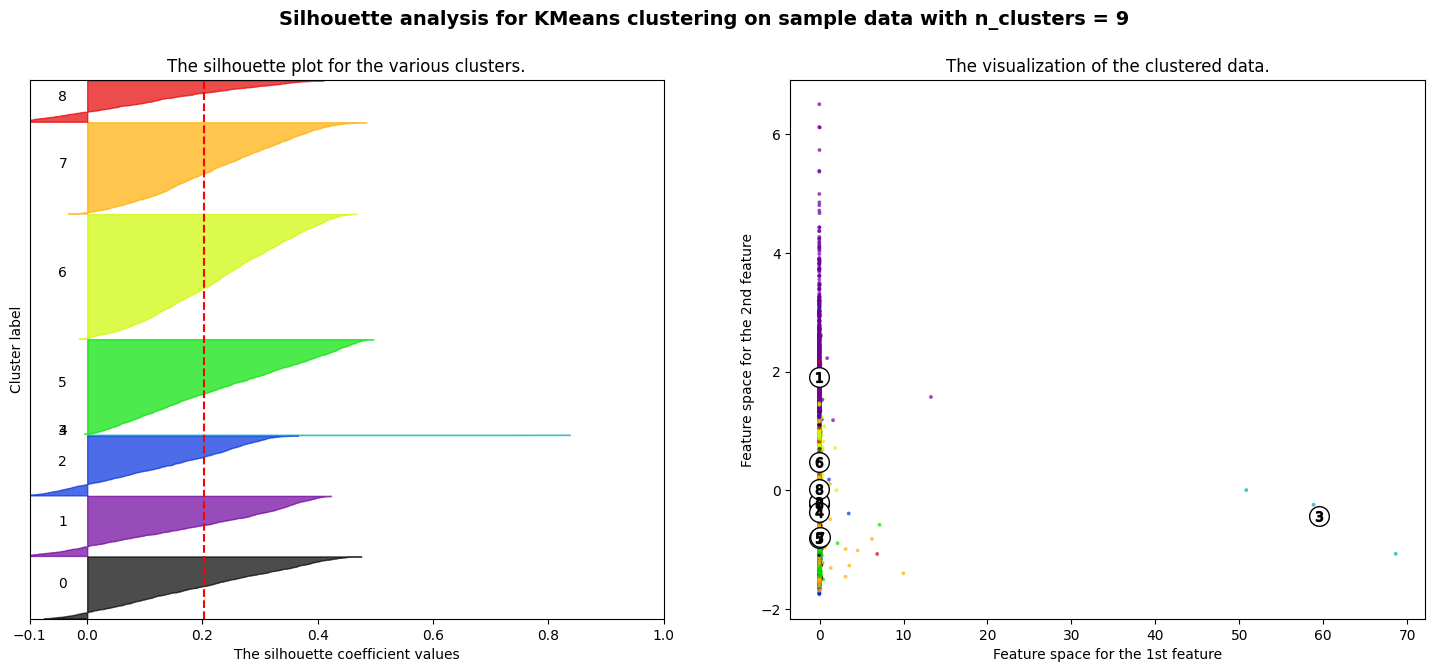

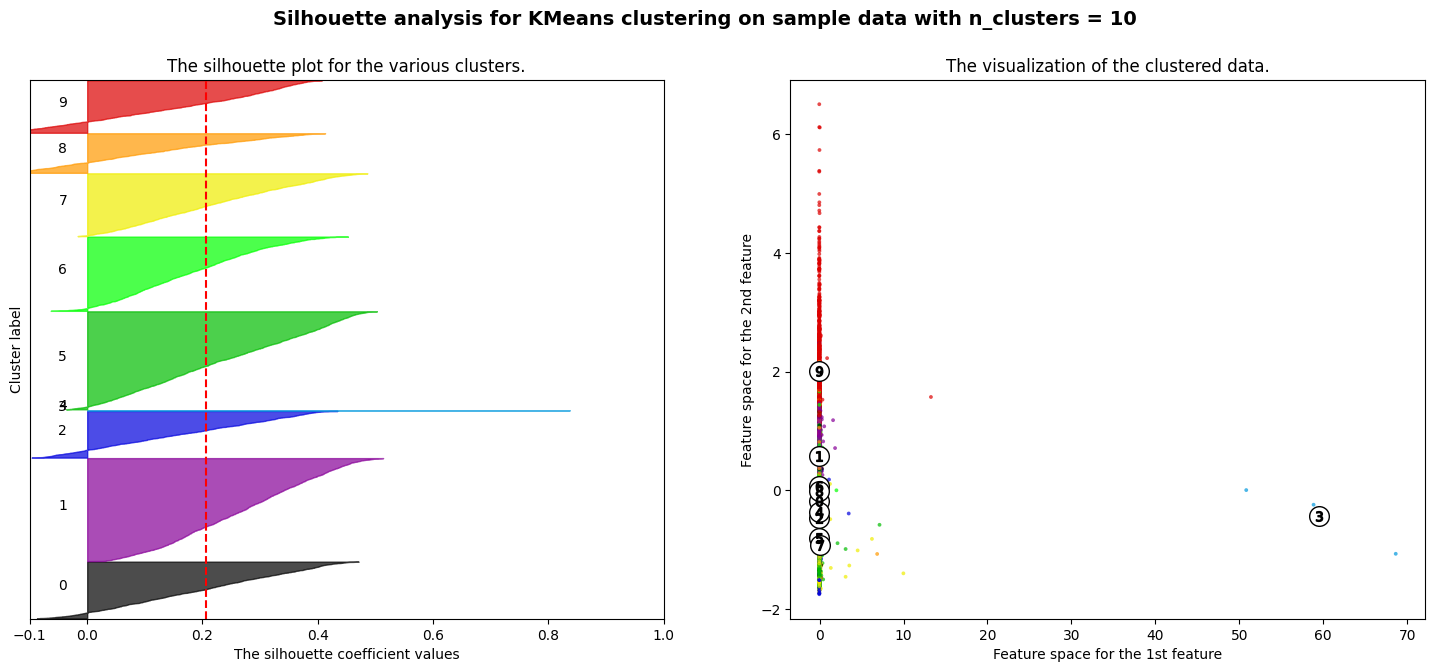

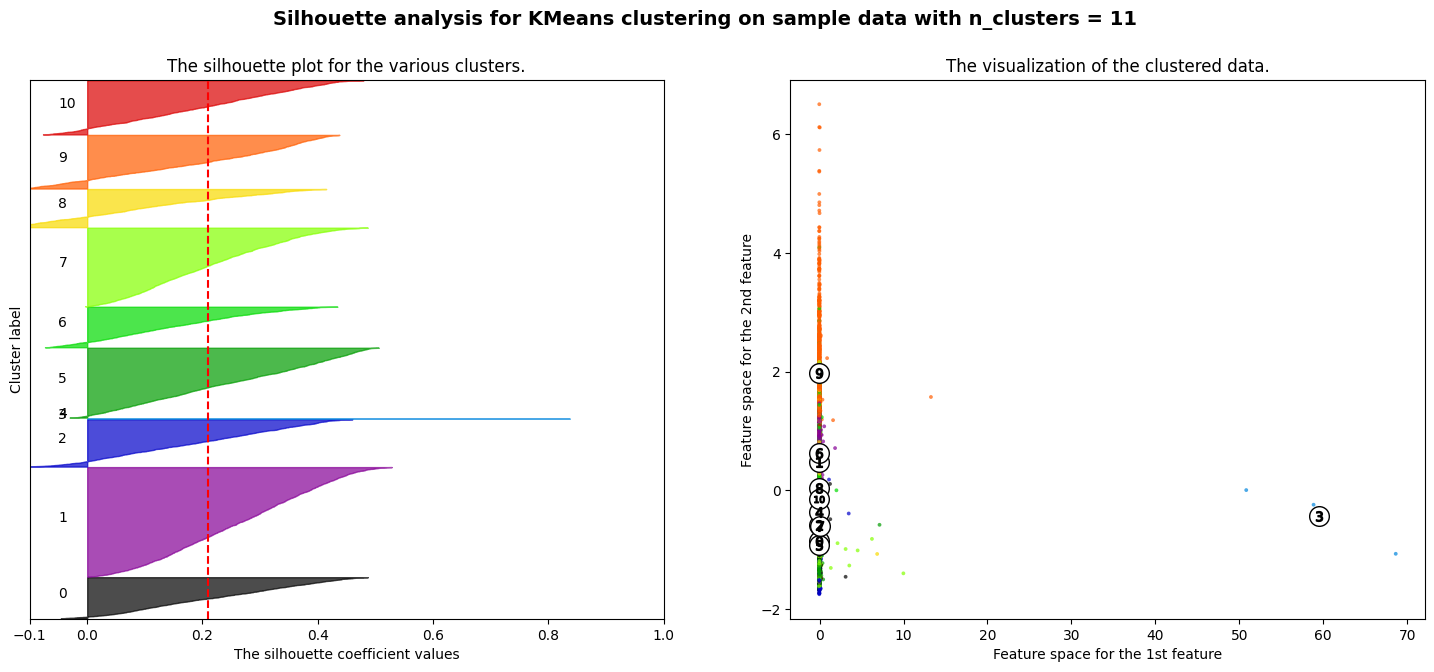

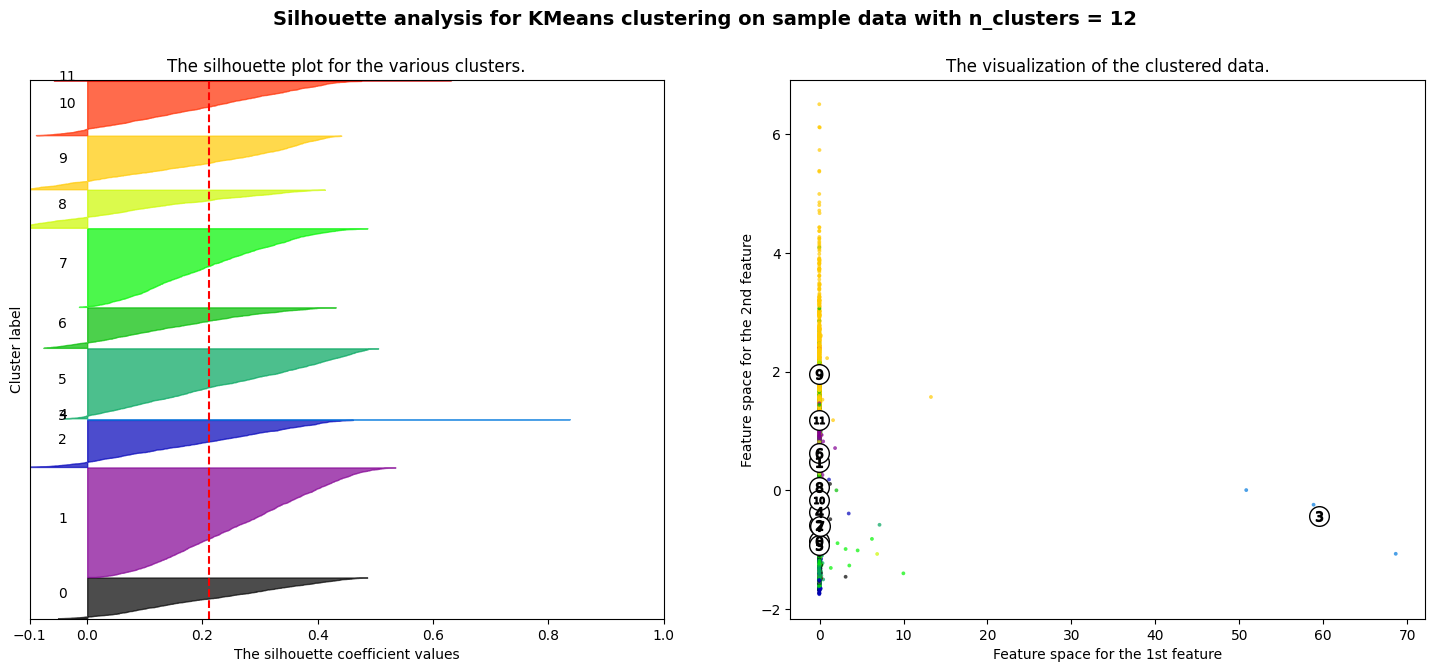

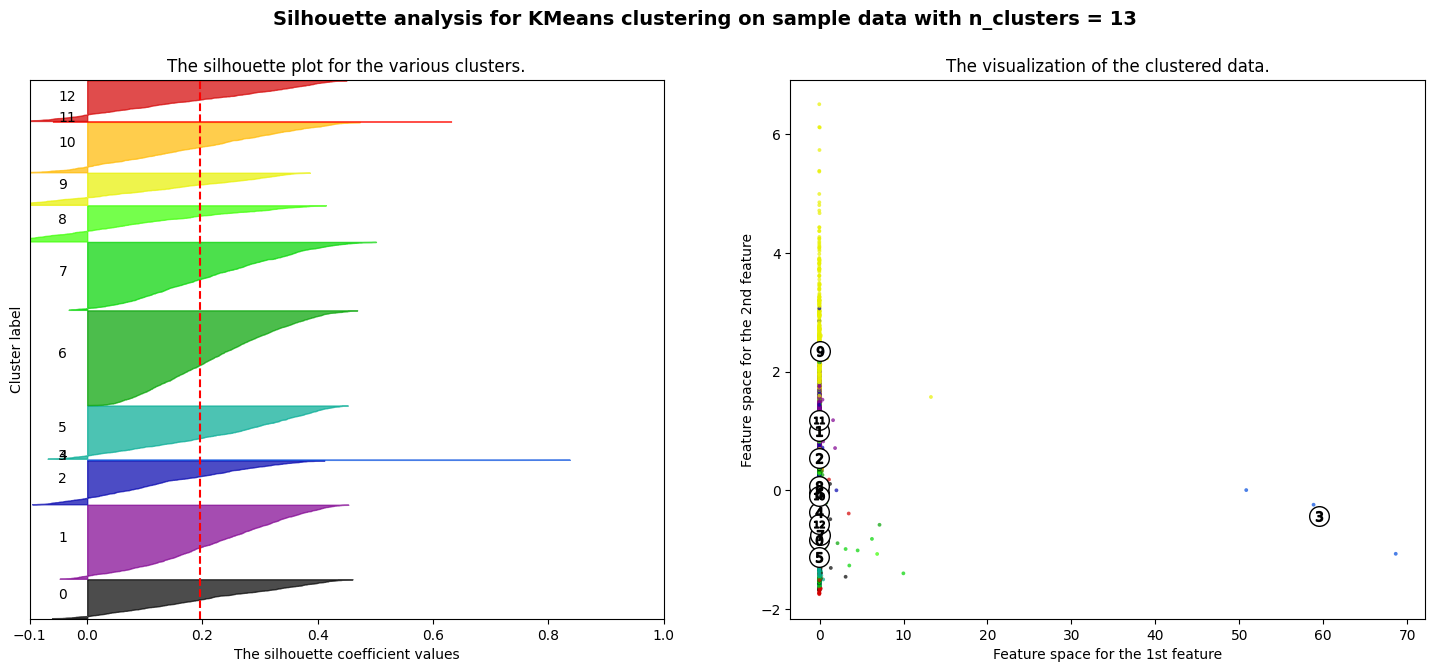

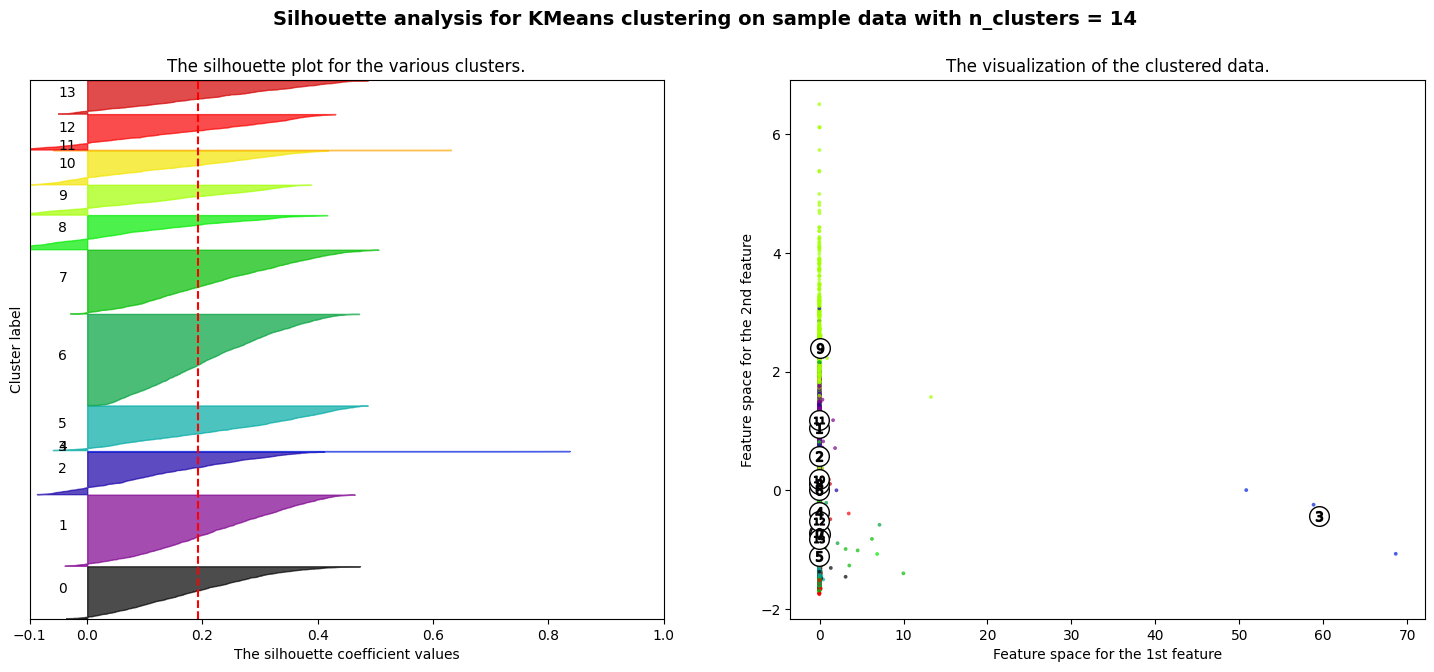

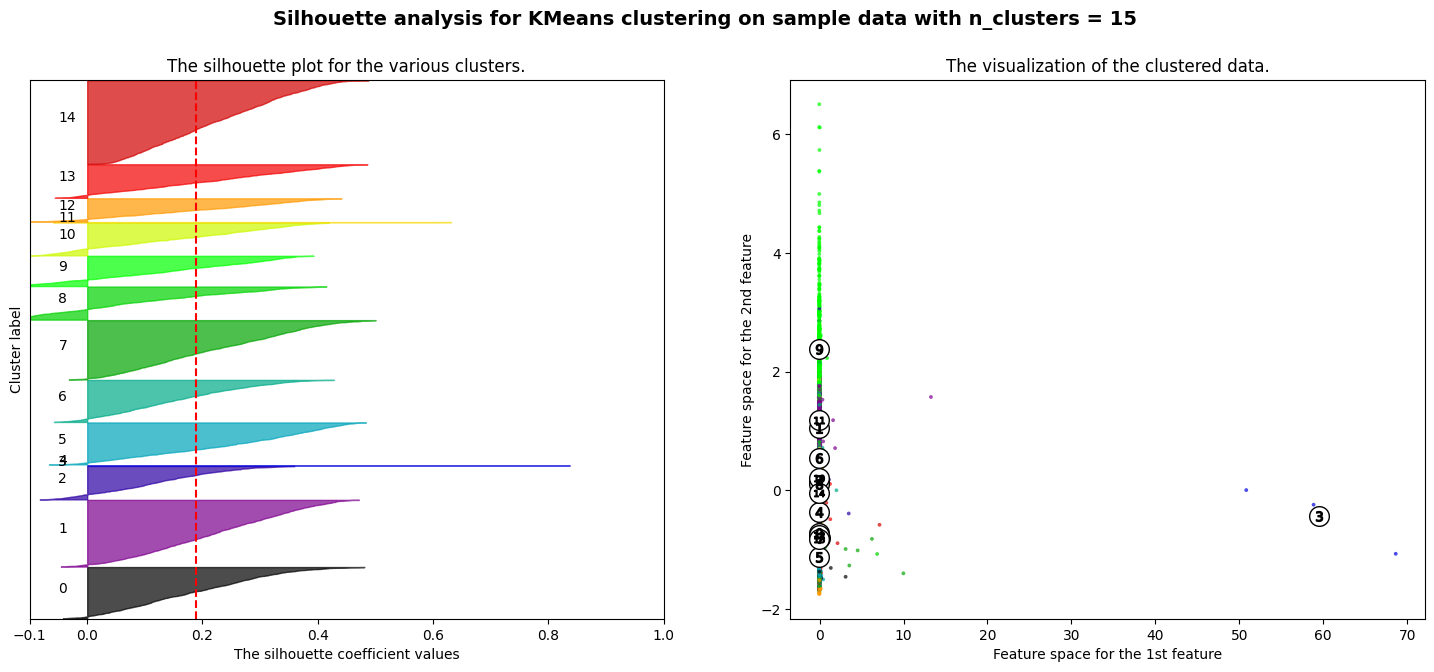

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

X = X_scaled

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()